In [36]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from utils_pipeline import *
from utils_evaluate import *
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
import os

In [37]:
BASE_DIR = os.getcwd()

# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = "shape_features"
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAIN_DIR = os.path.join(DATA_DIR,"TrainningDataset_reduced.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TEST_DIR = os.path.join(DATA_DIR,"TestingDataset_reduced.csv")


In [38]:
# X contain basic features, volumes and border of each segmentation as well as weight and age of each person.
X = pd.read_csv(TRAIN_DIR)
y = pd.read_csv(LABEL_DIR)
X_test = pd.read_csv(TEST_DIR)

# Assurez-vous que les identifiants sont bien formatés avec des zéros
X["Id"] = X["Id"].astype(str).str.zfill(3)
y["Id"] = y["Id"].astype(str).str.zfill(3)

# Mélange des lignes de X
X = X.sample(frac=1, random_state=42).reset_index(drop=True)

# Réalignement parfait de y sur l’ordre de X
y = y.set_index("Id").loc[X["Id"]].reset_index()
y_train = y["Category"]

# Séparation des features
X_train = X.drop(columns=["Id"])

X_test["Id"] = X_test["Id"].astype(str).str.zfill(3)
X_test = X_test.drop(columns=["Id"])


In [40]:
pipeline = ImbPipeline([ 
    ("normaliser" , MinMaxScaler()),                  
    ("classifier", RandomForestClassifier()),
])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'normaliser', 'dataAugment', 'classifier', 'normaliser__copy', 'normaliser__with_mean', 'normaliser__with_std', 'dataAugment__k_neighbors', 'dataAugment__kind', 'dataAugment__m_neighbors', 'dataAugment__random_state', 'dataAugment__sampling_strategy', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__monotonic_cst', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [41]:
# Cross Validation
# Seed of randomness to be able to compare different model more accuratly
cv = StratifiedKFold(shuffle=True)

In [42]:
param_grid = {
    'classifier__n_estimators': [100,150,200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [5,6,None],
    'classifier__min_samples_leaf': [2,3,4],
    "dataAugment__k_neighbors": [3, 5],
    "dataAugment__m_neighbors": [7, 10],
}

In [43]:
grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=cv,verbose=3,return_train_score=True)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100, dataAugment__k_neighbors=3, dataAugment__m_neighbors=7;, score=(train=0.988, test=1.000) total time=   0.1s
[CV 2/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100, dataAugment__k_neighbors=3, dataAugment__m_neighbors=7;, score=(train=1.000, test=0.950) total time=   0.0s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100, dataAugment__k_neighbors=3, dataAugment__m_neighbors=7;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100, dataAugment__k_neighbors=3, dataAugment__m_neighbors=7;, score=(train=1.000, test=0.800) 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('normaliser', StandardScaler()),
                                       ('dataAugment',
                                        BorderlineSMOTE(sampling_strategy={0: 22,
                                                                           1: 22,
                                                                           2: 22,
                                                                           3: 22,
                                                                           4: 22})),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [5, 6, None],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [2, 3, 4],
                         'classifier__n_estimators': [100, 150, 200],
                         'dataAugment__k_neighbors': [3, 5],
                         'dataAugment__m_neighbors': [7, 10]},
             return_train_score=True, verbose=3)

The model is fitted and now we want to properly evaluate the results. 
We select only the result from the best_params founded by the search. (Reminder that the best params are the one that provided the best mean validation score)

In [45]:
# set of parameters that gave the best cv result
best_params = grid_search.best_params_
print(f"best parameters : {best_params} ")

# Detailed result of the cross validation for each set of parameters
results = grid_search.cv_results_

# CV result for the best paramaters.

# GOAL : 
# The closest to 1 the mean score is on the val set the better
# The smallest the std on the val set the better.
best_idx = results['params'].index(best_params)
mean_train_score = results['mean_train_score'][best_idx]
mean_valid_score = results['mean_test_score'][best_idx]
std_train_score = results['std_train_score'][best_idx]
std_valid_score = results['std_test_score'][best_idx]
print(f"score validation set : {mean_valid_score,std_valid_score}")
print(f"score trainning set : {mean_train_score,std_train_score}")

best parameters : {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 150, 'dataAugment__k_neighbors': 5, 'dataAugment__m_neighbors': 7} 
score validation set : (0.96, 0.058309518948453015)
score trainning set : (0.9875, 0.011180339887498959)


In [46]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE

best_pipeline = grid_search.best_estimator_
inference_steps = [
    (name, step)
    for name, step in best_pipeline.steps
    if name != "dataAugment" # on ne bruite plus les données 
]
inf_pipeline = Pipeline(inference_steps)
print(inf_pipeline.get_params())

{'memory': None, 'steps': [('normaliser', StandardScaler()), ('classifier', RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_estimators=150))], 'verbose': False, 'normaliser': StandardScaler(), 'classifier': RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_estimators=150), 'normaliser__copy': True, 'normaliser__with_mean': True, 'normaliser__with_std': True, 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__monotonic_cst': None, 'classifier__n_estimators': 150, 'classifier__n_jobs': None, 'classifier__oob_score': False, 'classifier__random_state': None, 'classifier__verbose': 0, 'classifier__w

In [47]:
f_importance = grid_search.best_estimator_.named_steps["classifier"].feature_importances_
f_name = grid_search.best_estimator_.named_steps["normaliser"].get_feature_names_out()
feature_importance = pd.DataFrame({
    "feature": f_name,
    "importance": f_importance
})
feature_importance.sort_values("importance", ascending=False, inplace=True)
print(feature_importance)

                                              feature  importance
10  ED_LV_shape_VoxelVolume_over_ES_LV_shape_Voxel...    0.095552
6   ED_RV_shape_VoxelVolume_over_ED_LV_shape_Voxel...    0.086157
8   ED_RV_shape_VoxelVolume_over_ES_LV_shape_Voxel...    0.084353
12  ED_MY_shape_VoxelVolume_over_ES_LV_shape_Voxel...    0.082652
3                      ES_LV_shape_SurfaceVolumeRatio    0.082415
14  ES_RV_shape_VoxelVolume_over_ED_MY_shape_Voxel...    0.081294
13  ES_RV_shape_VoxelVolume_over_ED_LV_shape_Voxel...    0.079430
0                         ED_LV_shape_LeastAxisLength    0.069343
9   ED_LV_shape_VoxelVolume_over_ED_RV_shape_Voxel...    0.059169
4                              ES_MY_shape_Sphericity    0.057301
11  ED_MY_shape_VoxelVolume_over_ED_RV_shape_Voxel...    0.057020
7   ED_RV_shape_VoxelVolume_over_ED_MY_shape_Voxel...    0.052107
5                      ES_MY_shape_SurfaceVolumeRatio    0.046498
2                              ED_MY_shape_Sphericity    0.033951
1         

In [48]:
print(feature_importance[0:5]["feature"].tolist())

['ED_LV_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume', 'ED_RV_shape_VoxelVolume_over_ED_LV_shape_VoxelVolume', 'ED_RV_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume', 'ED_MY_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume', 'ES_LV_shape_SurfaceVolumeRatio']


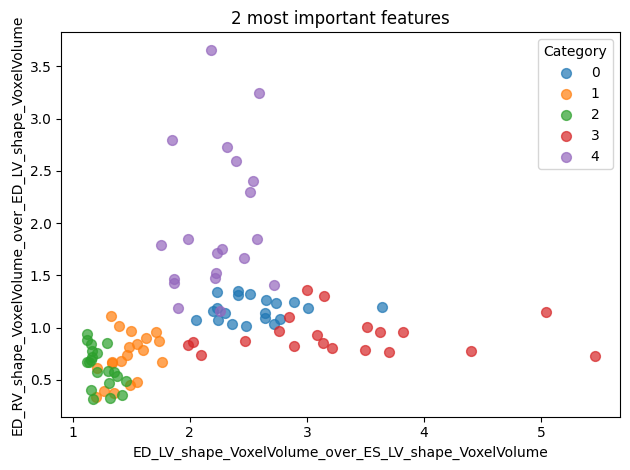

In [49]:
import matplotlib.pyplot as plt


df = X.copy()
df['Category'] = y["Category"]

fig, ax = plt.subplots()
for cat, sub in df.groupby('Category'):
    F = feature_importance[:]["feature"].to_list()
    F1,F2 = F[0],F[1]
    ax.scatter(sub[F1], sub[F2], label=cat, s=50, alpha=0.7)
ax.set_xlabel(F1)
ax.set_ylabel(F2)
ax.set_title('2 most important features')
ax.legend(title='Category')
plt.tight_layout()
plt.show()

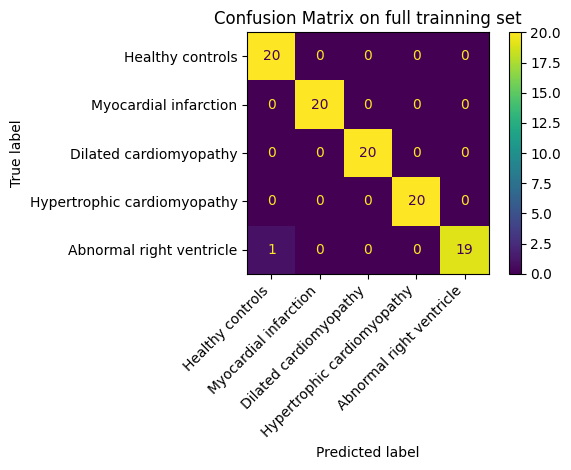

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      0.95      0.97        20

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [50]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

class_names = {0 : "Healthy controls",
                1: "Myocardial infarction",
                2: "Dilated cardiomyopathy",
                3: "Hypertrophic cardiomyopathy",
                4 : "Abnormal right ventricle"
}
labels = sorted(class_names.keys())
y_pred = inf_pipeline.predict(X_train)

disp = ConfusionMatrixDisplay.from_predictions(
    y["Category"], y_pred,
    display_labels=[class_names[i] for i in labels],     
)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')
disp.ax_.set_title("Confusion Matrix on full trainning set")
plt.tight_layout()
plt.savefig("conf_mat_baseline_model.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

print(classification_report(y_train,y_pred))

In [51]:
# Get the probabilities to get better insight on the model performance

proba = inf_pipeline.predict_proba(X_train)
print(f"average entropy score : {np.mean(certainty_score(proba))}")
print(f"\naverage margin score : {np.mean(margin_score(proba))}\n")
# Below 
treshold = 0.4
L = [0,0,0,0,0]
for x in proba : 
    a= 0
    index = []
    for ind,i in enumerate(x) :
        if i > treshold : 
            a+=1
            index.append(ind)
    if a >=2 : 
        for j in index : 
            L[j] +=1  
#print(proba)  
print(L)

average entropy score : 0.7636146328342934

average margin score : 0.7873945770806824

[0, 2, 2, 0, 0]


In [52]:
# Predict on the test set
import os

submission_name = "submission_baseline_model_mrmr_15_oversampling_hardsamples.csv"
submission_dataframe = pd.DataFrame(columns=["Id","Category"])
submission_dataframe["Id"] = X_test.index + 101 

y_test_pred = inf_pipeline.predict(X_test)
submission_dataframe["Category"] = y_test_pred
submission_dataframe.to_csv(os.path.join(os.getcwd(),submission_name),index=False)

print("File saved")

File saved


Below two cells to save the results : the model and the description of the method used.

In [98]:
description = "Baseline model computed with shape features. MinmaxScaler + Randomforest with GridSearch." 
other_params = "50 features were decided after variance treshold + correclation treshold + mrmr : minimum rendundancy maximum releance : "
name_folder = "Baseline_model_with_mrmr"
feature_used = f_name
informationDict = {
    "description": description,
    "model parameters" : best_params,
    "features used" : feature_used,
    "mean test accuracy with best params" : mean_valid_score ,
    "std  test with best params" : std_valid_score,
    "mean train accuracy with best params" : mean_train_score,
    "std train best params" : std_train_score,
    "other parms" : other_params,
    
}

# REPREDICTING PREDICTION THAT HAVE LOW PROBABILITIES

In [64]:
import joblib
from datetime import datetime
import os

# Create a timestamp
currentDateTime = datetime.now()

# Get the base directory (current directory)
BASE_DIR = os.getcwd()
print(f"BASE_DIR: {BASE_DIR}")
RESULT_DIR = os.path.join(BASE_DIR,"output")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)
    print(f"Directory created: {RESULT_DIR}")

# Create a folder named 'pipeline_<timestamp>' in the current directory
dir_name = name_folder
dir_path = os.path.join(RESULT_DIR, dir_name)

# If the directory doesn't exist, create it
if not os.path.exists(dir_path):
    os.mkdir(dir_path)
    print(f"Directory created: {dir_path}")

# Save the model inside this new folder
model_filename = 'pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.pkl'
model_path = os.path.join(dir_path, model_filename)

# This is where you'd have your model defined
joblib.dump(grid_search, model_path)
print(f"Model saved to: {model_path}")


# Saving feature importance : 
feature_importance_filename ='pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.csv' 
feature_importance_dir = os.path.join(dir_path,feature_importance_filename)
feature_importance.to_csv(feature_importance_dir)


# SAVING Description 
dict_filename = 'params.txt'
dict_path = os.path.join(dir_path, dict_filename)

with open(dict_path, 'w') as f:
    for key, val in informationDict.items():
        f.write(f"{key} : {val}\n")
print(f"Information about the model saved to: {dict_path}")


BASE_DIR: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction
Directory created: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/Baseline_model_with_mrmr
Model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/Baseline_model_with_mrmr/pipeline_00-53-33.pkl
Information about the model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/Baseline_model_with_mrmr/params.txt
